原始数据 (行:温度, 列:时间):
     0            3             6              9             12            15  \
温度                                                                              
20℃   0  2033.333333  13100.000000  182444.444444  1.101500e+06  4.933333e+06   
25℃   0  3133.333333  16900.000000  144000.000000  4.312222e+05  1.450000e+07   
28℃   0  3133.333333  13900.000000  124000.000000  7.640000e+05  5.383333e+06   
30℃   0  1863.333333   5893.333333   12500.000000  2.680000e+05  9.380000e+05   

               18            21            24            27            30  
温度                                                                         
20℃  6.080000e+07  1.066667e+08  4.915000e+08  7.499091e+08  7.716667e+08  
25℃  1.390000e+08  3.196667e+08  7.355000e+08  8.209091e+08  8.526667e+08  
28℃  7.750000e+07  1.756667e+08  6.716667e+08  8.366667e+08  8.241667e+08  
30℃  2.383333e+07  5.383333e+07  3.066667e+08  6.466667e+08  7.466667e+08  

转置后的数据 (行:时间, 列:温度):
温度           20℃

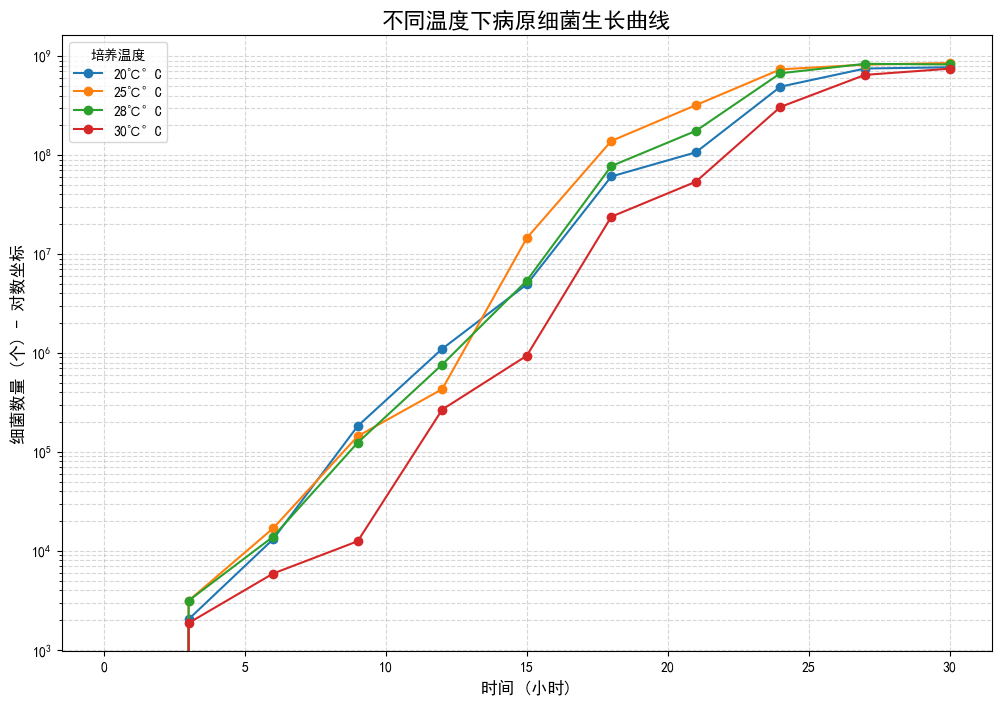

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
#在图标中间显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']    # Set the font to SimHei for Chinese characters.
plt.rcParams['axes.unicode_minus'] = False      # Ensure that minus signs are displayed correctly.

# Read the Excel file
df2 = pd.read_excel('附件2.xlsx', sheet_name='Sheet1', header=1, nrows=5)




# === 步骤 1: 读取并清洗数据 ===
# 使用我们之前确定的最佳方法
df2 = pd.read_excel(
    '附件2.xlsx',
    skiprows=1,   # 跳过总标题
    nrows=5,      # 读取表头+4行数据
    index_col=0   # 温度列作为索引
)

# 清洗列名 (时间)
df2.columns = df2.columns.str.replace('h', '').astype(int)
# 清洗索引 (温度)
df2.index = df2.index.str.replace('°C', '')

print("原始数据 (行:温度, 列:时间):")
print(df2)


# === 步骤 2: 转置数据以便于绘图 ===
# .T 是转置操作
df2_transposed = df2.T
print("\n转置后的数据 (行:时间, 列:温度):")
print(df2_transposed)


# === 步骤 3: 循环绘制曲线 ===
plt.figure(figsize=(12, 8)) # 创建一个大一点的画布

# 遍历转置后DataFrame的每一列（每一列代表一个温度）
for temp_col in df2_transposed.columns:
    plt.plot(
        df2_transposed.index,              # X轴：时间 (转置后的索引)
        df2_transposed[temp_col],          # Y轴：细菌数量 (当前列的数据)
        marker='o',                        # 在每个数据点上加个圆圈标记
        linestyle='-',                     # 用实线连接数据点
        label=f'{temp_col}°C'              # 图例标签，例如 "20°C"
    )

# === 步骤 4: 美化图表 ===
plt.title('不同温度下病原细菌生长曲线', fontsize=16)
plt.xlabel('时间 (小时)', fontsize=12)
plt.ylabel('细菌数量 (个)', fontsize=12)

# 使用对数坐标轴，因为细菌数量级差别太大
# 这样可以更清楚地看到初期的增长情况
plt.yscale('log')
plt.ylabel('细菌数量 (个) - 对数坐标', fontsize=12) # 更新Y轴标签

plt.grid(True, which="both", ls="--", alpha=0.5) # 显示网格线，'both'对主次刻度都有效
plt.legend(title='培养温度') # 显示图例
plt.show() # 显示图像

--- 线性相关性检验 (R²值) ---
温度      生长速率 r         决定系数 R²        
----------------------------------------
20℃°C    0.6673         0.9912         
25℃°C    0.6706         0.9706         
28℃°C    0.6302         0.9975         
30℃°C    0.5420         0.9525         
----------------------------------------


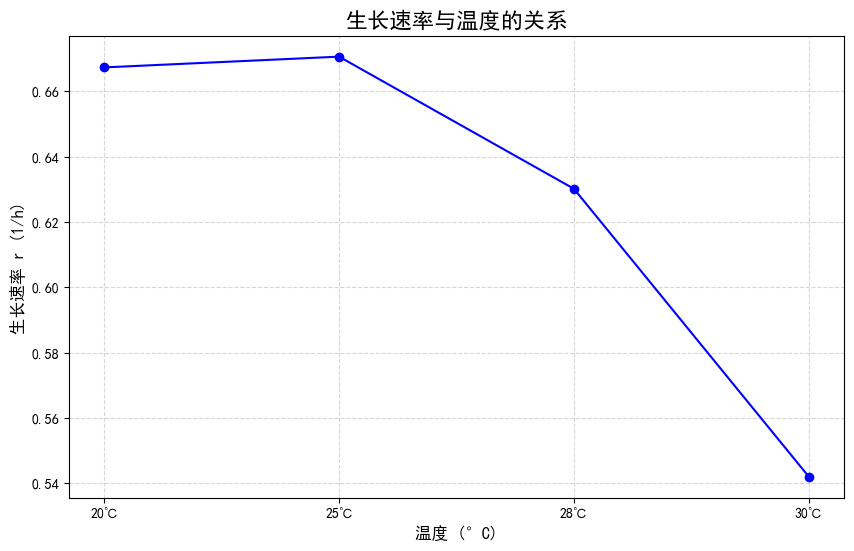

In [3]:
from sklearn.metrics import r2_score # 导入R²计算函数

# === 步骤 5: 线性相关性检验 (R²值) ===

# --- 循环计算 r 和 R² ---
print("--- 线性相关性检验 (R²值) ---")
print(f"{'温度':<8}{'生长速率 r':<15}{'决定系数 R²':<15}")
print("-" * 40)

# 准备存储结果
temperatures = []
growth_rates = []

for temp, row_data in df2.iterrows():
    
    # 提取用于拟合的数据点 (同样选择稳定增长期)
    time_points = row_data.index[1:6].to_numpy() # 转换为numpy数组
    bacteria_counts = row_data.values[1:6]
    
    valid_indices = bacteria_counts > 0
    t = time_points[valid_indices]
    N = bacteria_counts[valid_indices]
    
    if len(t) < 2:
        continue
        
    ln_N = np.log(N)
    
    # 1. 线性拟合，得到斜率和截距
    slope, intercept = np.polyfit(t, ln_N, 1)
    
    # 2. 计算预测值
    #    根据拟合出的直线 y = slope * x + intercept 计算每个t对应的ln(N)预测值
    ln_N_pred = slope * t + intercept
    
    # 3. 计算R²值
    #    比较 真实值(ln_N) 和 预测值(ln_N_pred)
    r_squared = r2_score(ln_N, ln_N_pred)
    
    # 打印结果
    print(f"{temp}°C    {slope:<15.4f}{r_squared:<15.4f}")
    
    # 存储用于后续建模的数据
    temperatures.append(temp)
    growth_rates.append(slope)

print("-" * 40)

# === 步骤 6: 绘制生长速率与温度的关系图 ===
plt.figure(figsize=(10, 6))
plt.plot(
    temperatures, 
    growth_rates, 
    marker='o', 
    linestyle='-', 
    color='blue'
)
plt.title('生长速率与温度的关系', fontsize=16)
plt.xlabel('温度 (°C)', fontsize=12)
plt.ylabel('生长速率 r (1/h)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(temperatures)  # 确保X轴刻度显示所有
plt.show()  # 显示图像